# Classification Tests

spiegazione test

### Imports

In [ ]:
import re
import xml.etree.ElementTree as ET
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import it_core_news_sm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import collections
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# Skopt functions
from sklearn.metrics import make_scorer, f1_score, recall_score
from skopt import BayesSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from skopt import gp_minimize # Bayesian optimization using Gaussian Processes
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import math
import scipy.stats
import sys
from info_gain import info_gain

In [ ]:
#nltk.download('punkt')

## Classes

In [ ]:
class CarWordsHandler:
    # https://github.com/n8barr/automotive-model-year-data
    def __init__(self, cars_file):
        self.brands_list = set()
        self.models_list = set()
        f = open(cars_file, "r")
        cars_list = f.read().splitlines()
        for i in range(len(cars_list)):
            brand = cars_list[i].split(',')[0][1:].lower()
            model = cars_list[i].split(',')[1][0:-1].lower()
            self.brands_list.add(brand)
            self.models_list.add(model)
        # remove some useless models
        self.models_list.remove('i')
        #self.models_list.remove('gli')
        #self.models_list.remove('estate')
        self.brands_list = list(self.brands_list)
        self.models_list = list(self.models_list)
        self.brands_list.sort()
        self.models_list.sort()
    
    # binary search to get if a word is a brand 
    def isBrand(self, word):
        word = word.lower()
        first = 0
        last = len(self.brands_list) -1
        while first < last:
            mid = int((last + first) / 2)
            if word == self.brands_list[mid]:
                return True
            elif word < self.brands_list[mid]:
                last = mid
            elif word > self.brands_list[mid]:
                first = mid
            if last-first == 1:
                if self.brands_list[first] == word or self.brands_list[last] == word:
                    return True
                else:
                    return False
    # binary search to get if a word is a brand 
    def isModel(self, word):
        word = word.lower()
        first = 0
        last = len(self.models_list) -1
        while first < last:
            mid = int((last + first) / 2)
            if word == self.models_list[mid]:
                return True
            elif word < self.models_list[mid]:
                last = mid
            elif word > self.models_list[mid]:
                first = mid
            if last-first == 1:
                if self.models_list[first] == word or self.models_list[last] == word:
                    return True
                else:
                    return False

In [ ]:
a = CarWordsHandler('resources/cars.txt')
a.models_list
a.isModel('e 110')

## Functions

In [5]:
# encoding issues
def correctEncodings(comment):
    fin_comment = comment
    fin_comment = re.sub('Ã¨', 'è', fin_comment)
    fin_comment = re.sub('Ã©', 'é', fin_comment)
    fin_comment = re.sub('Ã¬', 'ì', fin_comment)
    fin_comment = re.sub('Ã²', 'ò', fin_comment)
    fin_comment = re.sub('Ã¹', 'ù', fin_comment)
    fin_comment = re.sub('Ã', 'à', fin_comment)
    return fin_comment
# tokenize function
def tokenize(text):
    tokens = nltk.word_tokenize(text, 'italian')
    italian_stopwords = stopwords.words('italian')
    return [token for token in tokens if not token in italian_stopwords]
# recognize an URL
def isURL(word):
    # http://forum.rusconi.it/gentemotori/viewtopic.php ? t=434&sid=57c88f1b507d8f57717ea18e74e25324Â 
    return len(re.findall("^((http(s){0,1}://)|(www.))\S+$", word)) > 0
# recognize an image tag
def isPicture(word):
    return len(re.findall("^<img.*>$", word)) > 0
# remove punctation
def removePunctation(comment):
    return re.sub(r'\s{2,}', ' ', str(re.sub(r'[\'\"\,\.,\:\-]', ' ', comment)))
# fix issues on urls
def replaceURLs(comment):
    return str(re.sub(r'(http(s){0,1}://|www.)(([^\s]+)|/)+((\s\?\s)[^\s]+){0,1}', 'URL', comment)).replace(u'\xa0', u' ')
# replace images
def replaceIMGs(comment):
    return str(re.sub(r'<img.+>', 'IMG', comment))
# replace brands
def replaceBrands(cwhandler, comment):
    tokens = tokenize(comment)
    for i in range(len(tokens)):
        if cwhandler.isBrand(tokens[i]):
            tokens[i] = 'BRAND'
    return ' '.join(tokens)
# replace models
def replaceModels(cwhandler, comment):
    tokens = tokenize(comment)
    for i in range(len(tokens)):
        if cwhandler.isModel(tokens[i]):
            tokens[i] = 'MODEL'
    return ' '.join(tokens)
# replace question marks
def replaceQMarks(comment):
    comment = re.sub(r'\?{2,}', ' MULTI_QMARK', comment)
    comment = re.sub(r'\?', ' QMARK', comment)
    return comment
# replace esclamation marks
def replaceEMarks(comment):
    comment = re.sub(r'\!{2,}', ' MULTI_EMARK', comment)
    comment = re.sub(r'\!', ' EMARK', comment)
    return comment
# remove character repetitions
def removeRepeat(comment):
    return re.sub(r'(a-zA-Z)\1{2,}', r'\1\1\1', comment)
# replace speed
def replaceSpeed(comment):
    return re.sub(r'([0-9\.*]+(\s*(\-|\/|\s)\s*)+){0,1}[0-9\.*]+(\s*)(km\/h|mph|kmh)', 'SPEED', comment)
# replace consumption
def replaceConsumption(comment):
    return re.sub(r'([0-9\.*]+(\s*(\-|\/|\s)\s*)+){0,1}[0-9\.*]+(\s*)(km\/l|mpg)', 'CONSUMPTION', comment)
# replace weight
def replaceWeight(comment):
    return re.sub(r'[0-9\.*]+(\s*)(kg|tonnellate|ton|chili|kili)', 'WEIGHT', comment)
# replace power + torque
def replacePower(comment):
    return re.sub(r'[0-9]+\s*(cv|nm|kw)', 'POWER', comment)
# replace distance
def replaceDistance(comment):
    return re.sub(r'([0-9\.*]+(\s*(\-|\/|\s)\s*)+){0,1}[0-9\.*]+(\s*)(km|miles|kilometri|chilometri)', 'DISTANCE', comment)
# replace numbers
def replaceNumbers(comment):
    return re.sub(r'[0-9]{3,}', 'NUMBER', comment)


Sentiment http://valeriobasile.github.io/twita/sentix.html

In [6]:
class ItalianWordsHandler:
    # https://dspace-clarin-it.ilc.cnr.it/repository/xmlui/handle/20.500.11752/ILC-73
    def __init__(self, words_file):
        # words information
        self.words_dict = dict()
        root = ET.parse(words_file).getroot()
        for entry in root.findall('Lexicon/LexicalEntry'):
            word = entry.find('Lemma').get('writtenForm')
            pos = entry.get('partOfSpeech')
            senti = entry.find('Sense/Sentiment').get('polarity')
            conf = entry.find('Sense/Confidence').get('score')
            self.words_dict[word] = {'POS': pos, 'Sentiment': senti, 'Confidence': conf}
        # stemmer
        self.it_stem = nltk.stem.SnowballStemmer("italian", ignore_stopwords=True)
        
    # get word info. None if not exists
    def getWordInfo(self, word):
        # fields: POS, Sentiment, Confidence
        return self.words_dict.get(word)
    
    # italian stemmer http://snowball.tartarus.org/algorithms/italian/stemmer.html
    def stem(self, comment):
        tokens = tokenize(comment)
        return ' '.join([token if token.isupper() else self.it_stem.stem(token) for token in tokens])
    
    # correct words
    def correctWords(self, text):
        # not yet implemented
        return text

In [7]:
class Preprocessor:
    
    def __init__(self):
        self.cwh = CarWordsHandler('resources/cars.txt')
        self.iwh = ItalianWordsHandler('resources/ita_opeNER.xml')
        self.pos = it_core_news_sm.load()
    # preprocess text
    # allowed methods: word, swnt, pos
    # ner (named entity recognition), replacing for instance 100 km/h with SPEED
    def preprocessText(self, text, method='word', use_stemmer=False, ner=False):
        if method not in ['word', 'pos', 'swnt']:
            raise ValueError('Method not recognized. Select from word, swnt, pos')
        # correct encodings (not yet implemented)
        fin_text = correctEncodings(text)
        # remove punctation
        fin_text = removePunctation(fin_text)
        # some basic preprocessing
        fin_text = fin_text.lower()
        # correct words (not yet)
        fin_text = self.iwh.correctWords(fin_text)
        # manage repetitions
        fin_text = removeRepeat(fin_text)
        # manage punctation
        fin_text = replaceQMarks(fin_text)
        fin_text = replaceEMarks(fin_text)
        # manage URLs
        fin_text = replaceURLs(fin_text)
        # manage Images
        fin_text = replaceIMGs(fin_text)
        # remove stopwords
        tokens = tokenize(fin_text)
        fin_text = ' '.join(tokens) 
        # NOW DEPENDS ON NER
        if ner:
            # manage brands and models
            fin_text = replaceBrands(self.cwh, fin_text)
            fin_text = replaceModels(self.cwh, fin_text)
            # manage speed consumption and weight
            fin_text = replaceSpeed(fin_text)
            fin_text = replaceConsumption(fin_text)
            fin_text = replaceWeight(fin_text)
            fin_text = replacePower(fin_text)
            fin_text = replaceDistance(fin_text)
            fin_text = replaceNumbers(fin_text)
        # NOW DEPENDS ON METHOD
        if method == 'word':
            # just do nothing except eventually stemming
            if use_stemmer:
                tokens = tokenize(fin_text)
                fin_text = ' '.join([t if t.isupper() else self.iwh.stem(t) for t in tokens]) 
        elif method == 'swnt':
            tokens = tokenize(fin_text)
            swnt_tokens = []
            for t in tokens:
                info = self.iwh.getWordInfo(t)
                if info == None or info['Sentiment'] == None:
                    swnt_tokens.append(t)
                else:
                    # confidence 0-100
                    swnt_tokens.append(str(info['Sentiment'])[:3].upper() + '_' + str(int(float(info['Confidence'])*10)))
            fin_text = ' '.join(swnt_tokens)
            # stemmer
            if use_stemmer:
                tokens = tokenize(fin_text)
                fin_text = ' '.join([t if t.isupper() else self.iwh.stem(t) for t in tokens]) 
        elif method == 'pos':
            doc = self.pos(fin_text)
            pos_tokens = []
            # pos
            for t in doc:
                pos_tokens.append(str(t.pos_))
            # pos_word
            for t in doc:
                pos_tokens.append(str(t.pos_) + '_' + str(t))
                    
            fin_text = ' '.join(pos_tokens)
            # stemmer
            if use_stemmer:
                fin_text = self.iwh.stem(fin_text) 
        
        return str(re.sub(r'\s{2,}', ' ', fin_text))

Preprocessing Example

In [8]:
text = 'Sono reali calcolati nel arco del tutto anno nel estate qualcosa in piÃ¹ causa gomme di 17" e climatizzatore nel inverno un po di meno. Per quanto riguarda le autostrade quelle che percorro io principalmente la A4 e molto congestionata cosi spesso la media e 110-115 km/h che ovviamente influisce positivamente a i consumi. Ma quello che mi piace di piÃ¹ Ã¨ assenza dei guasti. Sulla vecchia Accord il primo guasto lo ho avuto a 200000 km si Ã¨ rotto il termostato della clima. Ogni tanto faccio giro di altri forum e leggo delle turbine rotte catene di distribuzione progettate male iniettori fatti male mah nel 2015 per me sono le cose incomprensibili . Con tutti gli difetti che puÃ² avere preferisco la Honda. '
print(text)
print('##########################################################################################')
p = Preprocessor()
print(p.preprocessText(text, ner=True, use_stemmer=True, method='word'))
print('##########################################################################################')
print(p.preprocessText(text, ner=True, use_stemmer=False, method='swnt'))
print('##########################################################################################')
print(p.preprocessText(text, ner=True, use_stemmer=True, method='pos'))


Sono reali calcolati nel arco del tutto anno nel estate qualcosa in piÃ¹ causa gomme di 17" e climatizzatore nel inverno un po di meno. Per quanto riguarda le autostrade quelle che percorro io principalmente la A4 e molto congestionata cosi spesso la media e 110-115 km/h che ovviamente influisce positivamente a i consumi. Ma quello che mi piace di piÃ¹ Ã¨ assenza dei guasti. Sulla vecchia Accord il primo guasto lo ho avuto a 200000 km si Ã¨ rotto il termostato della clima. Ogni tanto faccio giro di altri forum e leggo delle turbine rotte catene di distribuzione progettate male iniettori fatti male mah nel 2015 per me sono le cose incomprensibili . Con tutti gli difetti che puÃ² avere preferisco la Honda. 
##########################################################################################
real calcol arco anno MODEL qualcos caus gomm MODEL climatizz invern po men riguard autostrad percorr principal MODEL molt congestion cos spess med MODEL SPEED ovvi influ posit consum piac assen

For each comment divide Text from Quote by setting _TEXT or _QUOTE at the end of each word. This after preprocessing

In [9]:
def combine_text_quote(text, quote, divide_quote=True):
    text_tokens = tokenize(text)
    quote_tokens = tokenize(quote)
    combined_tokens = []
    for tt in text_tokens:
        if divide_quote:
            combined_tokens.append(str(tt) + '_TEXT')
        else:
            combined_tokens.append(str(tt))
    for qt in quote_tokens:
        if divide_quote:
            combined_tokens.append(str(qt) + '_QUOTE')
        else:
            combined_tokens.append(str(qt))
    return ' '.join(combined_tokens)

In [10]:
print(combine_text_quote('Bene grazie', 'ciao come va', divide_quote=False))

Bene grazie ciao va


# Dataset

In [72]:
column = 'Motore'

In [73]:
original_dataset = pd.read_csv('dataset.csv').fillna('')[['TESTO', '(Testo Citato)', column]]
dataset = original_dataset.copy()
dataset

,TESTO,(Testo Citato),Motore
0,Allora il problema è che non sono aggiornati i...,,irrilevante
1,E' virgolettato appositamente.... E soprattutt...,,irrilevante
2,Mah io sulla mappa ev-way ho visto solo tipo 2...,'Inferiore non s ma probabilmente uguale (il m...,irrilevante
3,Ah però.... uno pensa di averne viste tante su...,Sinceramente una differenza di 9.800? non mi p...,irrilevante
4,Basta darsi delle regole e per questo tipo di ...,,irrilevante
5,Personalmente posso ritenermi un possessore di...,,irrilevante
6,Confermo che il posteriore è riuscitissimo e a...,"""sono stato anch'io in conce per altri motivi ...",irrilevante
7,Mi sa che l'unica cosa apprezzabile del rst è ...,,irrilevante
8,grazie ! ! ! ! !,,irrilevante
9,Cosimo hai centrato completamente,,irrilevante


Preprocessing

In [74]:
pp = Preprocessor()
# TESTO
for i in range(len(dataset)):
    dataset['TESTO'][i] = pp.preprocessText(dataset['TESTO'][i], method='word', use_stemmer=True, ner=True)
# (Testo Citato)
for i in range(len(dataset)):
    dataset['(Testo Citato)'][i] = pp.preprocessText(dataset['(Testo Citato)'][i], method='word', use_stemmer=True, ner=True)    

In [75]:
# combine labels "molto positivo" = "positivo" and so on
dataset[column] = dataset[column].replace('molto positivo', 'positivo')
dataset[column] = dataset[column].replace('molto negativo', 'negativo')

Vectorization

In [76]:
preprocessed_dataset = []
for i in range(len(dataset)):
    preprocessed_dataset.append((combine_text_quote(dataset['TESTO'][i], dataset['(Testo Citato)'][i], divide_quote=False), dataset[column][i]))

In [77]:
preprocessed_dataset[50]

('MODEL nessun chied dir fals chied sol difend indifend strateg EMARK ok dic ver dubit incazz best urland te dietr sopr sott camb EMARK MODEL camb EMARK fabv BRAND bisogn ( avvoc ) difensor bisogn attacc EMARK usat avvoc finor success raggiung strabil svolg compitin insegu lont concorrt EMARK twisted twisted twisted twisted twisted',
 'irrilevante')

Split into training and test

In [78]:
numpy_dataset = np.array(preprocessed_dataset)
print('Length: ' + str(numpy_dataset.shape[0]))

Length: 7183


In [79]:
np.random.seed(42)
# split 80% training and 20% test
# FARLO RISPETTANDO LA DISTRIBUZIONE
#perm = np.random.permutation(numpy_dataset.shape[0])
np.random.shuffle(numpy_dataset)
#numpy_dataset = numpy_dataset[perm]
#split = int(0.8 * numpy_dataset.shape[0])
#train_dataset, test_dataset = numpy_dataset[:split,:], numpy_dataset[split:,:]
train_dataset_X, test_dataset_X, train_dataset_y, test_dataset_y = train_test_split(numpy_dataset[:,0], numpy_dataset[:,1], test_size=0.2, stratify=numpy_dataset[:,1], random_state=42)
# split validation
train_dataset_X, valid_dataset_X, train_dataset_y, valid_dataset_y = train_test_split(train_dataset_X, train_dataset_y, test_size=0.2, stratify=train_dataset_y, random_state=42)

In [80]:
train_dataset_X.shape

(4596,)

Some statistics

In [81]:
collections.Counter(valid_dataset_y)

Counter({'irrilevante': 1017, 'positivo': 51, 'neutro': 57, 'negativo': 25})

Finally replace text with vector, and replace label with numerical representation

In [82]:
# VECTORIZE
vec = TfidfVectorizer(ngram_range=(1,2), lowercase=False)
#train_dataset_X = vec.fit_transform(train_dataset_X)

# final dataset for the classification
train_X = vec.fit_transform(train_dataset_X)
train_y = np.empty([train_dataset_y.shape[0], 1]).ravel()
valid_X = vec.transform(valid_dataset_X)
valid_y = np.empty([valid_dataset_y.shape[0], 1]).ravel()
# training
for i in range(train_dataset_y.shape[0]):
    if train_dataset_y[i] == 'irrilevante':
        train_y[i] = 0
    elif train_dataset_y[i] == 'positivo':
        train_y[i] = 1
    elif train_dataset_y[i] == 'neutro':
        train_y[i] = 1
    elif train_dataset_y[i] == 'negativo':
        train_y[i] = 1
# validation
for i in range(valid_dataset_y.shape[0]):
    if valid_dataset_y[i] == 'irrilevante':
        valid_y[i] = 0
    elif valid_dataset_y[i] == 'positivo':
        valid_y[i] = 1
    elif valid_dataset_y[i] == 'neutro':
        valid_y[i] = 1
    elif valid_dataset_y[i] == 'negativo':
        valid_y[i] = 1

Split train and validation

In [83]:
#train_X, valid_X_cf, train_y, valid_y_cf = train_test_split(train_X, train_y, test_size=0.2, stratify=train_y, random_state=42)

In [84]:
valid_X[0]

<1x155611 sparse matrix of type '<class 'numpy.float64'>'
	with 14 stored elements in Compressed Sparse Row format>

## SVM _TFIDF Classifier

https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a

First tests for feature selection

In [85]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

# f1, f1_macro (for multiclass), recall
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svm_clf, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf.fit(train_X, train_y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.3min finished


[LibSVM]Best parameters set found on development set:

{'C': 100.0}

Grid scores on development set:

0.000 (+/-0.000) for {'C': 0.001}
0.000 (+/-0.000) for {'C': 0.01}
0.000 (+/-0.000) for {'C': 0.1}
0.251 (+/-0.029) for {'C': 1.0}
0.361 (+/-0.059) for {'C': 10.0}
0.366 (+/-0.044) for {'C': 100.0}
0.366 (+/-0.044) for {'C': 1000.0}



Refit with best parameters and then draw confusion matrix on validation data

In [86]:
#train_X_cf, test_X_cf, train_y_cf, test_y_cf = train_test_split(train_X, train_y, test_size=0.2, stratify=train_y, random_state=42)

In [87]:
best_clf = svm.SVC(kernel='linear', C=clf.best_params_['C'], decision_function_shape='ovr', verbose=2, random_state=42)
best_clf.fit(train_X, train_y)

[LibSVM]

SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=2)

In [88]:
# predictions
pred_y = best_clf.predict(valid_X)

F1 score on validation data: 0.5128205128205129
Recall on validation data: 0.5263157894736842
Precision on validation data: 0.5


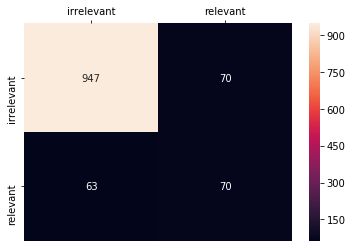

In [89]:
# 0=irrilevante, 1=rilevante
print('F1 score on validation data: ' + str(f1_score(valid_y, pred_y, average='binary')))
print('Recall on validation data: ' + str(recall_score(valid_y, pred_y)))
print('Precision on validation data: ' + str(precision_score(valid_y, pred_y)))
cm = confusion_matrix(valid_y, pred_y, labels=[0, 1])
ax = sns.heatmap(cm, annot=True, xticklabels=['irrelevant','relevant'], yticklabels=['irrelevant','relevant'], fmt="d")
ax.xaxis.set_ticks_position('top')

Features selection. Plot by descending weight

The weight/coefficient matrix of a generalised linear model predictor, of shape (n_features,) for binary classification and single-output regression, (n_classes, n_features) for multiclass classification and (n_targets, n_features) for multi-output regression. Note this does not include the intercept (or bias) term, which is stored in intercept_.

When available, feature_importances_ is not usually provided as well, but can be calculated as the norm of each feature’s entry in coef_.

https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights

In [90]:
weights = clf.best_estimator_.coef_
print(weights.shape)
# 6 perchè fa un classifictore per ogni coppia di labels (ovr) -> verificare

(1, 155611)


In [91]:
print(weights.indices)
print(weights.data)

[152060 145739 145732 ...   6462   5242   3836]
[ 0.08978086  0.08978086  0.08978086 ... -0.06697312  0.08989606
 -0.48689454]


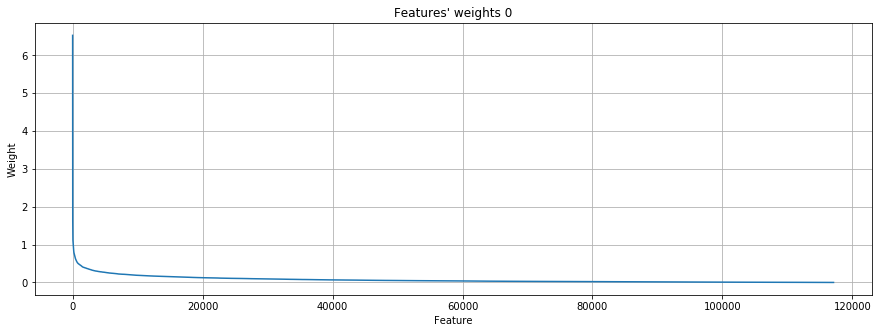

In [92]:
# Data for plotting
for i in range(weights.shape[0]):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(weights[i].data.shape[0]), sorted(abs(weights[i].data), reverse = True))
    ax.set(xlabel='Feature', ylabel='Weight', title='Features\' weights ' + str(i))
    ax.grid()
    #fig.savefig("test.png")
    plt.show()

In [93]:
# select most important features
cutoff_0 = 0.15
selected_features_0 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights[0].data)), weights[0].indices), reverse=True) if i[0] > cutoff_0]

In [94]:
# take the union of selected features (a word important for a classification may be not important for other classifications)
selected_features = set()
for f in selected_features_0:
    selected_features.add(f[1])
print('Selected ' + str(len(selected_features)) + ' features')    

Selected 15155 features


Now retry grid search using only selected features

In [95]:
train_X_fs = train_X[:, list(selected_features)]
train_y_fs = train_y
valid_X_fs = valid_X[:, list(selected_features)]
valid_y_fs = valid_y

In [96]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf_fs = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_fs = GridSearchCV(svm_clf_fs, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf_fs.fit(train_X_fs, train_y_fs)

    print("Best parameters set found on development set:")
    print()
    print(clf_fs.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_fs.cv_results_['mean_test_score']
    stds = clf_fs.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_fs.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   23.7s finished


[LibSVM]Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.000 (+/-0.000) for {'C': 0.001}
0.000 (+/-0.000) for {'C': 0.01}
0.000 (+/-0.000) for {'C': 0.1}
0.144 (+/-0.054) for {'C': 1.0}
0.516 (+/-0.066) for {'C': 10.0}
0.508 (+/-0.064) for {'C': 100.0}
0.514 (+/-0.082) for {'C': 1000.0}



New confusion matrix

In [97]:
# predictions
pred_y_fs = clf_fs.best_estimator_.predict(valid_X_fs)

F1 score on validation data: 0.5367647058823528
Recall on validation data: 0.5488721804511278


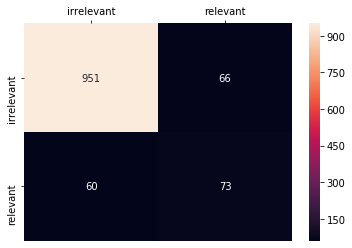

In [98]:
# 0=irrilevante, 1=positivo, 2=neutro, 3=negativo
print('F1 score on validation data: ' + str(f1_score(valid_y_fs, pred_y_fs)))
print('Recall on validation data: ' + str(recall_score(valid_y_fs, pred_y_fs)))
cm = confusion_matrix(valid_y_fs, pred_y_fs, labels=[0, 1])
ax = sns.heatmap(cm, annot=True, xticklabels=['irrelevant','relevant'], yticklabels=['irrelevant','relevant'], fmt="d")
ax.xaxis.set_ticks_position('top')

Most important features

### 0


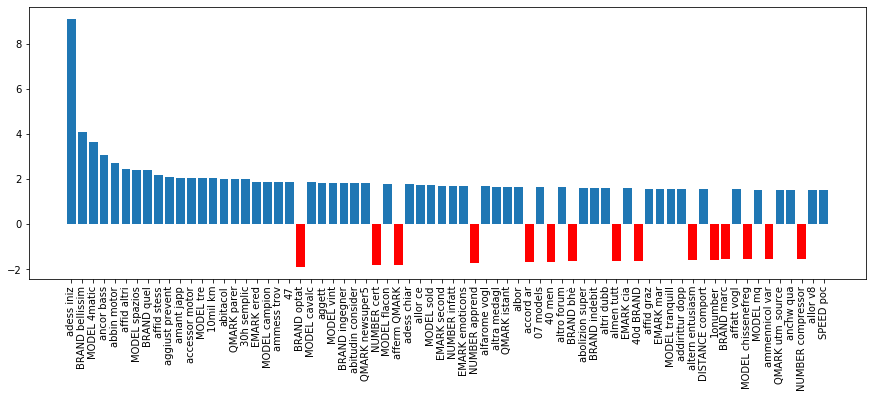

In [99]:
best_n = 70
feature_names = vec.get_feature_names()
for i in range(weights.shape[0]):
    print('### ' + str(i))
    fn = []
    fv = []
    f = [i for i in sorted(zip(map(lambda x: round(x, 4), clf_fs.best_estimator_.coef_[i].data), clf_fs.best_estimator_.coef_[i].indices), reverse=True, key=lambda k: abs(k[0]))][:best_n]
    for j in range(len(f)):
        fn.append(feature_names[f[j][1]])
        fv.append(f[j][0])
        #print(str(feature_names[f[j][1]]) + ': ' + str(f[j][0]))
    fig, ax = plt.subplots(figsize=(15,5))
    plt.bar([i for i in range(best_n) if fv[i]>0], [x for x in fv if x>0])
    plt.bar([i for i in range(best_n) if fv[i]<0], [x for x in fv if x<0], color='r')
    plt.xticks(range(best_n), fn, rotation='vertical')
    plt.show()

## Sentiment Classification

In [100]:
snt_dataset = original_dataset.copy()

Get only relevant rows

In [101]:
snt_dataset = snt_dataset.drop(snt_dataset[(snt_dataset[column] == 'irrilevante')].index).reset_index()
snt_dataset

,index,TESTO,(Testo Citato),Motore
0,11,Mah parleranno di ipotetiche versioni ibride o...,,negativo
1,13,SZ ES-30 ?,,neutro
2,17,Benvenuta nel posto giusto Allora sentirai div...,"""Buongiorno a tutti So che il titolo di questo...",neutro
3,18,Ma come c'è il gpl ! ! ! Ahahaha Nel 2010 se b...,,positivo
4,22,Hanno limiti di emissioni diversi come in Usa ...,,neutro
5,29,Per ora no rinviato a sabato prossimo,'ragazz scusate l OT e scusate se scrivo ben p...,positivo
6,36,Accorgimenti tecnici ma di base ( basamenti in...,,neutro
7,40,Non ho ancora ricevuto la risposta... e faccio...,,negativo
8,42,Buongiorno...rilancio con Renault.. Ho acquist...,,molto negativo
9,46,Ah la Cuore e' una Daia di piccola cilindrata....,,negativo


In [102]:
pp = Preprocessor()
# TESTO
for i in range(len(snt_dataset)):
    snt_dataset['TESTO'][i] = pp.preprocessText(snt_dataset['TESTO'][i], method='word', use_stemmer=True, ner=True)
# (Testo Citato)
for i in range(len(snt_dataset)):
    snt_dataset['(Testo Citato)'][i] = pp.preprocessText(snt_dataset['(Testo Citato)'][i], method='word', use_stemmer=True, ner=True)    

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [103]:
# combine labels "molto positivo" = "positivo" and so on
snt_dataset[column] = snt_dataset[column].replace('molto positivo', 'positivo')
snt_dataset[column] = snt_dataset[column].replace('molto negativo', 'negativo')

In [104]:
collections.Counter(snt_dataset[column])

Counter({'negativo': 155, 'neutro': 358, 'positivo': 317})

Vectorization

In [105]:
preprocessed_dataset_snt = []
for i in range(len(snt_dataset)):
    preprocessed_dataset_snt.append((combine_text_quote(snt_dataset['TESTO'][i], snt_dataset['(Testo Citato)'][i], divide_quote=False), snt_dataset[column][i]))

In [106]:
numpy_dataset_snt = np.array(preprocessed_dataset_snt)
print('Length: ' + str(numpy_dataset_snt.shape[0]))

Length: 830


In [109]:
np.random.seed(42)
# split 80% training and 20% test
# FARLO RISPETTANDO LA DISTRIBUZIONE
np.random.shuffle(numpy_dataset_snt)
#numpy_dataset = numpy_dataset[perm]
#split = int(0.8 * numpy_dataset.shape[0])
#train_dataset, test_dataset = numpy_dataset[:split,:], numpy_dataset[split:,:]
train_dataset_X_snt, test_dataset_X_snt, train_dataset_y_snt, test_dataset_y_snt = train_test_split(numpy_dataset_snt[:,0], numpy_dataset_snt[:,1], test_size=0.2, stratify=numpy_dataset_snt[:,1], random_state=42)
# split validation
train_dataset_X_snt, valid_dataset_X_snt, train_dataset_y_snt, valid_dataset_y_snt = train_test_split(train_dataset_X_snt, train_dataset_y_snt, test_size=0.2, stratify=train_dataset_y_snt, random_state=42)

In [110]:
test_dataset_X_snt.shape[0]

166

In [111]:
# VECTORIZE
vec_snt = TfidfVectorizer(ngram_range=(1,2), lowercase=False)
#train_dataset_X = vec.fit_transform(train_dataset_X)

# final dataset for the classification
train_X_snt = vec_snt.fit_transform(train_dataset_X_snt)
train_y_snt = np.empty([train_dataset_y_snt.shape[0], 1]).ravel()
valid_X_snt = vec_snt.transform(valid_dataset_X_snt)
valid_y_snt = np.empty([valid_dataset_y_snt.shape[0], 1]).ravel()
# training
for i in range(train_dataset_y_snt.shape[0]):
    if train_dataset_y_snt[i] == 'positivo':
        train_y_snt[i] = 0
    elif train_dataset_y_snt[i] == 'neutro':
        train_y_snt[i] = 1
    elif train_dataset_y_snt[i] == 'negativo':
        train_y_snt[i] = 2
# validation
for i in range(valid_dataset_y_snt.shape[0]):
    if valid_dataset_y_snt[i] == 'positivo':
        valid_y_snt[i] = 0
    elif valid_dataset_y_snt[i] == 'neutro':
        valid_y_snt[i] = 1
    elif valid_dataset_y_snt[i] == 'negativo':
        valid_y_snt[i] = 2

In [112]:
collections.Counter(valid_y_snt)

Counter({2.0: 25, 1.0: 57, 0.0: 51})

SVM_TFIDF_Classifier without feaure selection

In [113]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf_snt = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

# f1, f1_macro (for multiclass), recall
scores = ['f1_macro']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_snt = GridSearchCV(svm_clf_snt, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf_snt.fit(train_X_snt, train_y_snt)

    print("Best parameters set found on development set:")
    print()
    print(clf_snt.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_snt.cv_results_['mean_test_score']
    stds = clf_snt.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_snt.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1_macro

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    5.4s finished


[LibSVM]Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.201 (+/-0.001) for {'C': 0.001}
0.201 (+/-0.001) for {'C': 0.01}
0.201 (+/-0.001) for {'C': 0.1}
0.405 (+/-0.046) for {'C': 1.0}
0.410 (+/-0.076) for {'C': 10.0}
0.410 (+/-0.076) for {'C': 100.0}
0.410 (+/-0.076) for {'C': 1000.0}



In [115]:
# predictions
pred_y_snt = clf_snt.best_estimator_.predict(valid_X_snt)

F1 score macro on validation data: 0.4291537333541755
F1 score micro on validation data: 0.5263157894736842


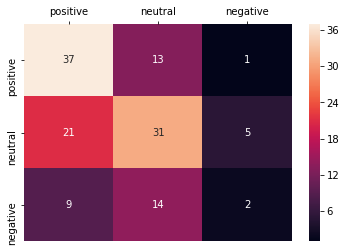

In [116]:
# 0=positivo, 1=neutro, 2=negativo
print('F1 score macro on validation data: ' + str(f1_score(valid_y_snt, pred_y_snt, average='macro')))
print('F1 score micro on validation data: ' + str(f1_score(valid_y_snt, pred_y_snt, average='micro')))
cm_snt = confusion_matrix(valid_y_snt, pred_y_snt, labels=[0, 1, 2])
ax = sns.heatmap(cm_snt, annot=True, xticklabels=['positive','neutral','negative'], yticklabels=['positive','neutral','negative'])
ax.xaxis.set_ticks_position('top')

Feature Selection

In [117]:
weights_snt = clf_snt.best_estimator_.coef_
print(weights.shape)
# 6 perchè fa un classifictore per ogni coppia di labels (ovr) -> verificare

(1, 155611)


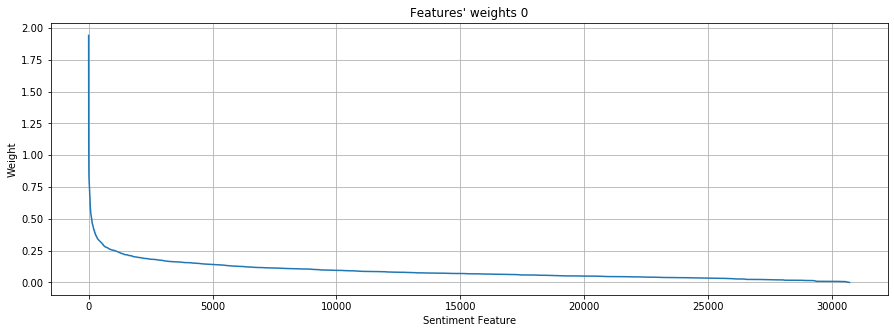

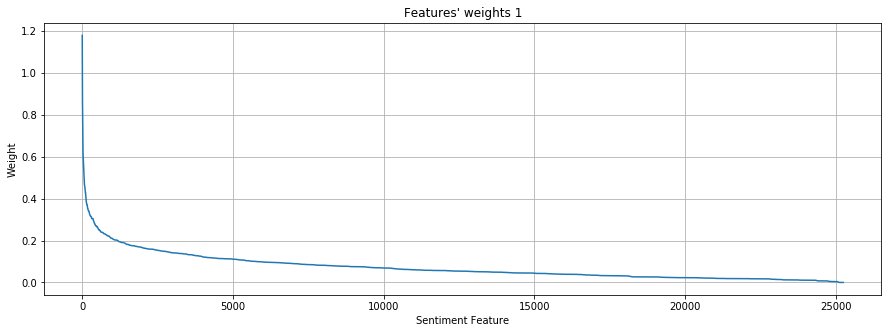

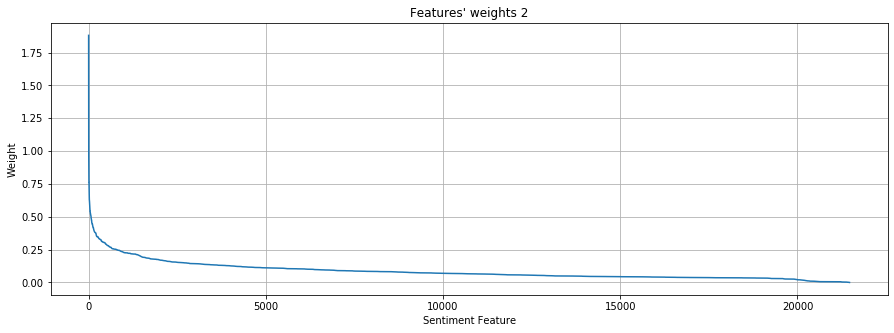

In [118]:
# Data for plotting
for i in range(weights_snt.shape[0]):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(weights_snt[i].data.shape[0]), sorted(abs(weights_snt[i].data), reverse = True))
    ax.set(xlabel='Sentiment Feature', ylabel='Weight', title='Features\' weights ' + str(i))
    ax.grid()
    #fig.savefig("test.png")
    plt.show()

In [132]:
# select most important features
cutoff_0 = 0.05
selected_features_snt_0 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_snt[0].data)), weights_snt[0].indices), reverse=True) if i[0] > cutoff_0]
cutoff_1 = 0.05
selected_features_snt_1 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_snt[1].data)), weights_snt[1].indices), reverse=True) if i[0] > cutoff_1]
cutoff_2 = 0.05
selected_features_snt_2 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_snt[2].data)), weights_snt[2].indices), reverse=True) if i[0] > cutoff_2]

In [133]:
# take the union of selected features (a word important for a classification may be not important for other classifications)
selected_features_snt = set()
for f in selected_features_snt_0:
    selected_features_snt.add(f[1])
for f in selected_features_snt_1:
    selected_features_snt.add(f[1])
for f in selected_features_snt_2:
    selected_features_snt.add(f[1])
print('Selected ' + str(len(selected_features_snt)) + ' features')    

Selected 26662 features


Retry with selected features

In [134]:
train_X_fs_snt = train_X_snt[:, list(selected_features_snt)]
train_y_fs_snt = train_y_snt
valid_X_fs_snt = valid_X_snt[:, list(selected_features_snt)]
valid_y_fs_snt = valid_y_snt

In [135]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf_fs_snt = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

scores = ['f1_macro']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_fs_snt = GridSearchCV(svm_clf_fs, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf_fs_snt.fit(train_X_fs_snt, train_y_fs_snt)

    print("Best parameters set found on development set:")
    print()
    print(clf_fs_snt.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_fs_snt.cv_results_['mean_test_score']
    stds = clf_fs_snt.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_fs.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1_macro

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    5.0s finished


[LibSVM]Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.201 (+/-0.001) for {'C': 0.001}
0.201 (+/-0.001) for {'C': 0.01}
0.201 (+/-0.001) for {'C': 0.1}
0.400 (+/-0.054) for {'C': 1.0}
0.412 (+/-0.056) for {'C': 10.0}
0.412 (+/-0.056) for {'C': 100.0}
0.412 (+/-0.056) for {'C': 1000.0}



In [136]:
# predictions
pred_y_fs_snt = clf_fs_snt.best_estimator_.predict(valid_X_fs_snt)

F1 macro score on validation data: 0.4282344938082643
F1 micro score on validation data: 0.5263157894736842


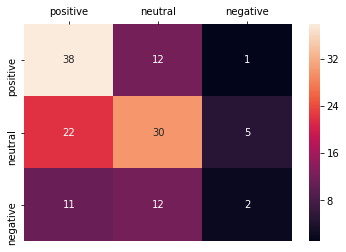

In [137]:
# 0=positivo, 1=neutro, 2=negativo
print('F1 macro score on validation data: ' + str(f1_score(valid_y_fs_snt, pred_y_fs_snt, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(valid_y_fs_snt, pred_y_fs_snt, average='micro')))
cm_fs_snt = confusion_matrix(valid_y_fs_snt, pred_y_fs_snt, labels=[0, 1, 2])
ax = sns.heatmap(cm_fs_snt, annot=True, xticklabels=['positive','neutral','negative'], yticklabels=['positive','neutral','negative'])
ax.xaxis.set_ticks_position('top')

### 0


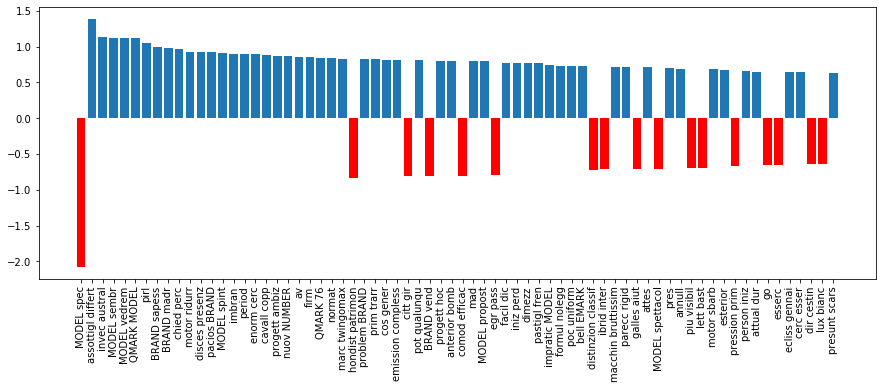

### 1


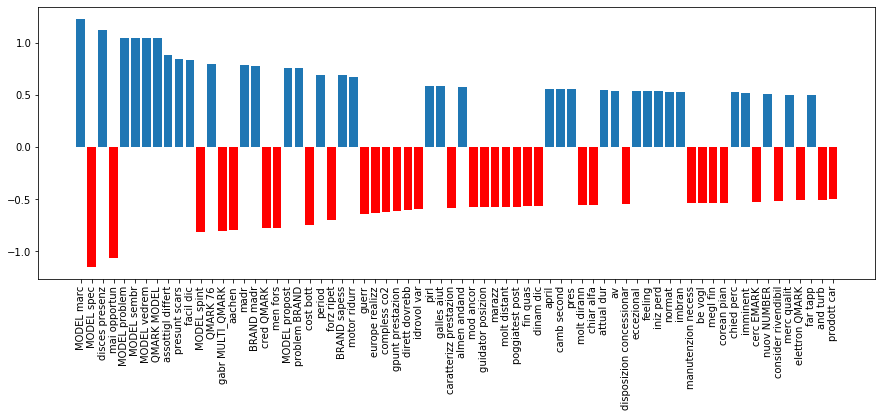

### 2


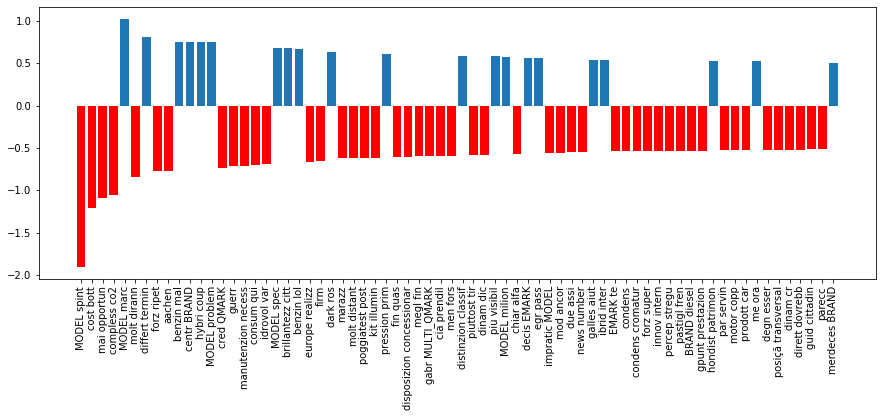

In [138]:
best_n = 70
feature_names_snt = vec_snt.get_feature_names()
for i in range(weights_snt.shape[0]):
    print('### ' + str(i))
    fn_snt = []
    fv_snt = []
    f_snt = [i for i in sorted(zip(map(lambda x: round(x, 4), clf_fs_snt.best_estimator_.coef_[i].data), clf_fs_snt.best_estimator_.coef_[i].indices), reverse=True, key=lambda k: abs(k[0]))][:best_n]
    for j in range(len(f_snt)):
        fn_snt.append(feature_names_snt[f_snt[j][1]])
        fv_snt.append(f_snt[j][0])
        #print(str(feature_names[f[j][1]]) + ': ' + str(f[j][0]))
    fig, ax = plt.subplots(figsize=(15,5))
    plt.bar([i for i in range(best_n) if fv_snt[i]>0], [x for x in fv_snt if x>0])
    plt.bar([i for i in range(best_n) if fv_snt[i]<0], [x for x in fv_snt if x<0], color='r')
    plt.xticks(range(best_n), fn_snt, rotation='vertical')
    plt.show()

## Classification with 4 labels

In [139]:
dataset_all = original_dataset.copy()
dataset_all

,TESTO,(Testo Citato),Motore
0,Allora il problema è che non sono aggiornati i...,,irrilevante
1,E' virgolettato appositamente.... E soprattutt...,,irrilevante
2,Mah io sulla mappa ev-way ho visto solo tipo 2...,'Inferiore non s ma probabilmente uguale (il m...,irrilevante
3,Ah però.... uno pensa di averne viste tante su...,Sinceramente una differenza di 9.800? non mi p...,irrilevante
4,Basta darsi delle regole e per questo tipo di ...,,irrilevante
5,Personalmente posso ritenermi un possessore di...,,irrilevante
6,Confermo che il posteriore è riuscitissimo e a...,"""sono stato anch'io in conce per altri motivi ...",irrilevante
7,Mi sa che l'unica cosa apprezzabile del rst è ...,,irrilevante
8,grazie ! ! ! ! !,,irrilevante
9,Cosimo hai centrato completamente,,irrilevante


Preprocessing

In [140]:
pp = Preprocessor()
# TESTO
for i in range(len(dataset_all)):
    dataset_all['TESTO'][i] = pp.preprocessText(dataset_all['TESTO'][i], method='word', use_stemmer=True, ner=True)
# (Testo Citato)
for i in range(len(dataset_all)):
    dataset_all['(Testo Citato)'][i] = pp.preprocessText(dataset_all['(Testo Citato)'][i], method='word', use_stemmer=True, ner=True)    

In [141]:
# combine labels "molto positivo" = "positivo" and so on
dataset_all[column] = dataset_all[column].replace('molto positivo', 'positivo')
dataset_all[column] = dataset_all[column].replace('molto negativo', 'negativo')

Vectorization

In [142]:
preprocessed_dataset_all = []
for i in range(len(dataset_all)):
    preprocessed_dataset_all.append((combine_text_quote(dataset_all['TESTO'][i], dataset_all['(Testo Citato)'][i], divide_quote=False), dataset_all[column][i]))

In [143]:
preprocessed_dataset_all[40]

('ancor ricev rispost gasol sempr stess rivenditor sent gir cap sol mercedes spieg DISTANCE ancor marciant dop esserm riforn stess rivenditor fus motor dop appen MODEL DISTANCE fatt nessun tutel dovrebb',
 'negativo')

Split into training and test

In [144]:
numpy_dataset_all = np.array(preprocessed_dataset_all)
print('Length: ' + str(numpy_dataset_all.shape[0]))

Length: 7183


In [145]:
np.random.seed(42)
# split 80% training and 20% test
# FARLO RISPETTANDO LA DISTRIBUZIONE
np.random.shuffle(numpy_dataset_all)
#numpy_dataset = numpy_dataset[perm]
#split = int(0.8 * numpy_dataset.shape[0])
#train_dataset, test_dataset = numpy_dataset[:split,:], numpy_dataset[split:,:]
#train_dataset_X_complete, test_dataset_X_complete, train_dataset_y_complete, test_dataset_y_complete = train_test_split(numpy_dataset_complete[:,0], numpy_dataset_complete[:,1], test_size=0.2, stratify=numpy_dataset_complete[:,1], random_state=42)

train_dataset_X_all, test_dataset_X_all, train_dataset_y_all, test_dataset_y_all = train_test_split(numpy_dataset_all[:,0], numpy_dataset_all[:,1], test_size=0.2, stratify=numpy_dataset_all[:,1], random_state=42)
# split validation
train_dataset_X_all, valid_dataset_X_all, train_dataset_y_all, valid_dataset_y_all = train_test_split(train_dataset_X_all, train_dataset_y_all, test_size=0.2, stratify=train_dataset_y_all, random_state=42)

In [146]:
train_dataset_X_all.shape

(4596,)

Some statistics

In [147]:
collections.Counter(train_dataset_y_all)

Counter({'irrilevante': 4065, 'positivo': 203, 'negativo': 99, 'neutro': 229})

Finally replace text with vector, and replace label with numerical representation

In [148]:
# VECTORIZE
vec_all = TfidfVectorizer(ngram_range=(1,2), lowercase=False)
#train_dataset_X = vec.fit_transform(train_dataset_X)

# final dataset for the classification
train_X_all = vec_all.fit_transform(train_dataset_X_all)
train_y_all = np.empty([train_dataset_y_all.shape[0], 1]).ravel()
valid_X_all = vec_all.transform(valid_dataset_X_all)
valid_y_all = np.empty([valid_dataset_y_all.shape[0], 1]).ravel()
# training
for i in range(train_dataset_y_all.shape[0]):
    if train_dataset_y_all[i] == 'irrilevante':
        train_y_all[i] = 0
    elif train_dataset_y_all[i] == 'positivo':
        train_y_all[i] = 1
    elif train_dataset_y_all[i] == 'neutro':
        train_y_all[i] = 2
    elif train_dataset_y_all[i] == 'negativo':
        train_y_all[i] = 3
# validation
for i in range(valid_dataset_y_all.shape[0]):
    if valid_dataset_y_all[i] == 'irrilevante':
        valid_y_all[i] = 0
    elif valid_dataset_y_all[i] == 'positivo':
        valid_y_all[i] = 1
    elif valid_dataset_y_all[i] == 'neutro':
        valid_y_all[i] = 2
    elif valid_dataset_y_all[i] == 'negativo':
        valid_y_all[i] = 3

SVM _TFIDF Classifier

In [149]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf_all = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

# f1, f1_macro (for multiclass), recall
scores = ['f1_macro']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_all = GridSearchCV(svm_clf_all, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf_all.fit(train_X_all, train_y_all)

    print("Best parameters set found on development set:")
    print()
    print(clf_all.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_all.cv_results_['mean_test_score']
    stds = clf_all.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_all.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1_macro

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  2.9min finished


[LibSVM]Best parameters set found on development set:

{'C': 100.0}

Grid scores on development set:

0.235 (+/-0.000) for {'C': 0.001}
0.235 (+/-0.000) for {'C': 0.01}
0.235 (+/-0.000) for {'C': 0.1}
0.246 (+/-0.015) for {'C': 1.0}
0.279 (+/-0.021) for {'C': 10.0}
0.283 (+/-0.017) for {'C': 100.0}
0.283 (+/-0.017) for {'C': 1000.0}



Refit with best parameters and then draw confusion matrix on validation data

In [150]:
# predictions
pred_y_all = clf_all.best_estimator_.predict(valid_X_all)

F1 macro score on validation data: 0.3560519696202013
F1 micro score on validation data: 0.8747826086956523


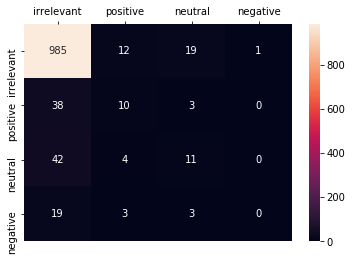

In [151]:
# 0=irrilevante, 1=positivo, 2=neutro, 3=negativo
print('F1 macro score on validation data: ' + str(f1_score(valid_y_all, pred_y_all, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(valid_y_all, pred_y_all, average='micro')))
cm_all = confusion_matrix(valid_y_all, pred_y_all, labels=[0, 1, 2, 3])
ax = sns.heatmap(cm_all, annot=True, xticklabels=['irrelevant','positive','neutral', 'negative'], yticklabels=['irrelevant','positive','neutral', 'negative'], fmt="d")
ax.xaxis.set_ticks_position('top')

Features selection. Plot by descending weight


In [152]:
weights_all = clf_all.best_estimator_.coef_
print(weights_all.shape)
# 6 perchè fa un classifictore per ogni coppia di labels (ovr) -> verificare

(6, 155611)


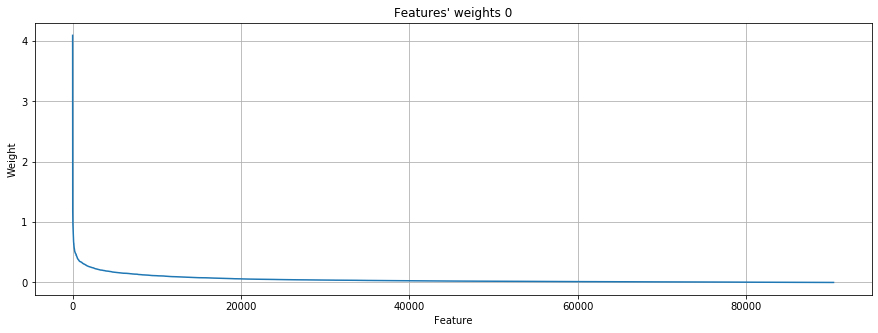

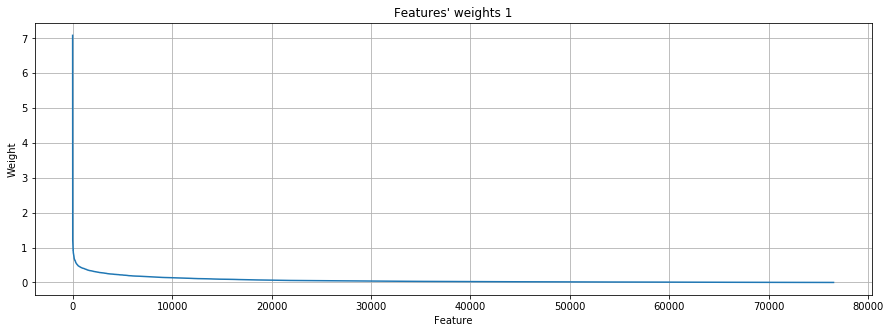

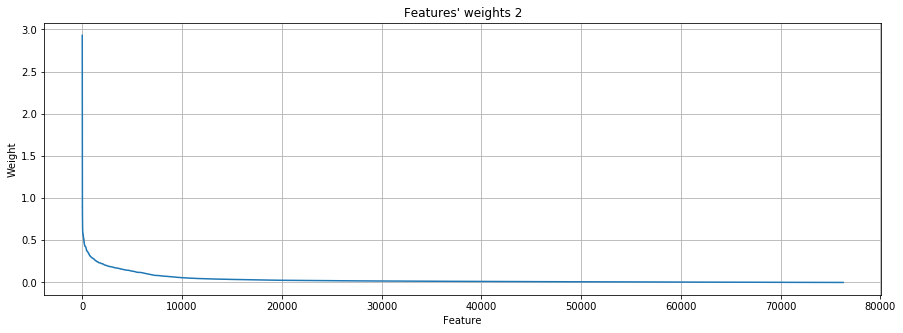

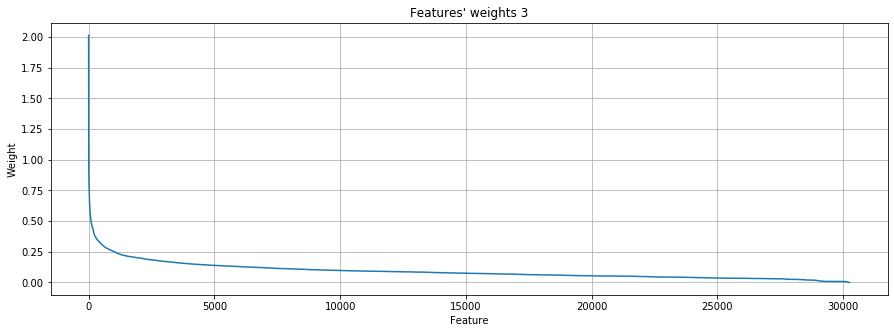

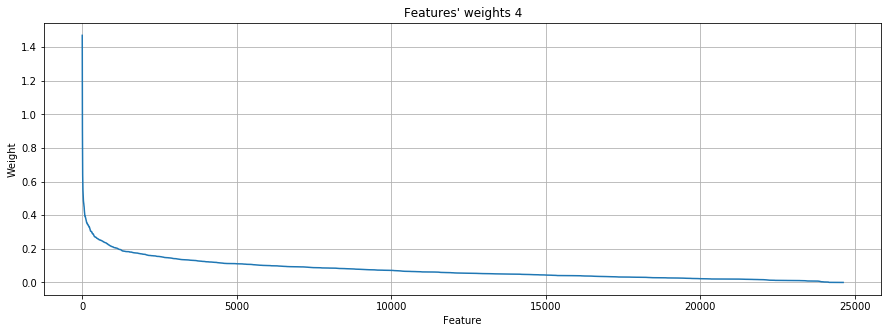

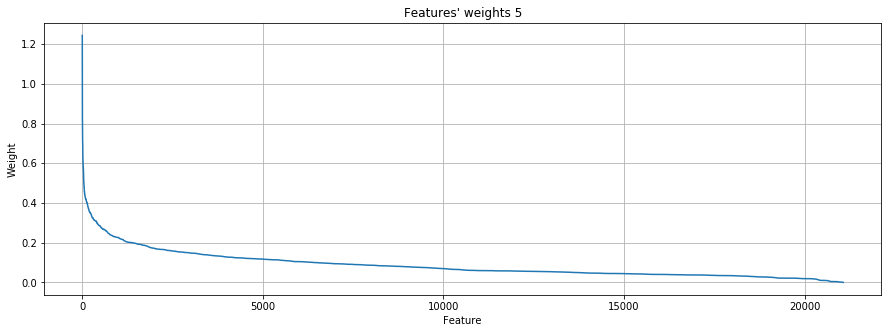

In [153]:
# Data for plotting
for i in range(weights_all.shape[0]):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(weights_all[i].data.shape[0]), sorted(abs(weights_all[i].data), reverse = True))
    ax.set(xlabel='Feature', ylabel='Weight', title='Features\' weights ' + str(i))
    ax.grid()
    #fig.savefig("test.png")
    plt.show()

In [156]:
# select most important features
cutoff_0 = 0.2
selected_features_all_0 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_all[0].data)), weights_all[0].indices), reverse=True) if i[0] > cutoff_0]
cutoff_1 = 0.2
selected_features_all_1 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_all[1].data)), weights_all[1].indices), reverse=True) if i[0] > cutoff_1]
cutoff_2 = 0.1
selected_features_all_2 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_all[2].data)), weights_all[2].indices), reverse=True) if i[0] > cutoff_2]
cutoff_3 = 0.1
selected_features_all_3 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_all[3].data)), weights_all[3].indices), reverse=True) if i[0] > cutoff_3]
cutoff_4 = 0.1
selected_features_all_4 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_all[4].data)), weights_all[4].indices), reverse=True) if i[0] > cutoff_4]
cutoff_5 = 0.1
selected_features_all_5 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_all[5].data)), weights_all[5].indices), reverse=True) if i[0] > cutoff_5]

In [157]:
# take the union of selected features (a word important for a classification may be not important for other classifications)
selected_features_all = set()
for f in selected_features_all:
    selected_features_all.add(f[1])
for f in selected_features_all_1:
    selected_features_all.add(f[1])
for f in selected_features_all_2:
    selected_features_all.add(f[1])
for f in selected_features_all_3:
    selected_features_all.add(f[1])
for f in selected_features_all_4:
    selected_features_all.add(f[1])
for f in selected_features_all_5:
    selected_features_all.add(f[1])
print('Selected ' + str(len(selected_features_all)) + ' features')    

Selected 17232 features


Now retry grid search using only selected features

In [158]:
train_X_fs_all = train_X_all[:, list(selected_features_all)]
train_y_fs_all = train_y_all
valid_X_fs_all = valid_X_all[:, list(selected_features_all)]
valid_y_fs_all = valid_y_all

In [159]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf_fs_all = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

scores = ['f1_macro']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_fs_all = GridSearchCV(svm_clf_fs_all, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf_fs_all.fit(train_X_fs_all, train_y_fs_all)

    print("Best parameters set found on development set:")
    print()
    print(clf_fs_all.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_fs_all.cv_results_['mean_test_score']
    stds = clf_fs_all.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_fs_all.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1_macro

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   32.6s finished


[LibSVM]Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.235 (+/-0.000) for {'C': 0.001}
0.235 (+/-0.000) for {'C': 0.01}
0.235 (+/-0.000) for {'C': 0.1}
0.235 (+/-0.000) for {'C': 1.0}
0.325 (+/-0.038) for {'C': 10.0}
0.325 (+/-0.039) for {'C': 100.0}
0.325 (+/-0.038) for {'C': 1000.0}



New confusion matrix

In [160]:
# predictions
pred_y_fs_all = clf_fs_all.best_estimator_.predict(valid_X_fs_all)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 macro score on validation data: 0.37189091651913386
F1 micro score on validation data: 0.88


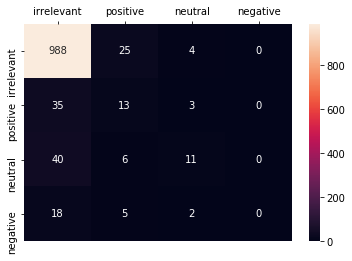

In [161]:
# 0=irrilevante, 1=positivo, 2=neutro, 3=negativo
print('F1 macro score on validation data: ' + str(f1_score(valid_y_fs_all, pred_y_fs_all, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(valid_y_fs_all, pred_y_fs_all, average='micro')))
cm = confusion_matrix(valid_y_fs_all, pred_y_fs_all, labels=[0, 1, 2, 3])
ax = sns.heatmap(cm, annot=True, xticklabels=['irrelevant','positive','neutral', 'negative'], yticklabels=['irrelevant','positive','neutral', 'negative'], fmt="d")
ax.xaxis.set_ticks_position('top')

Most important features

### 0


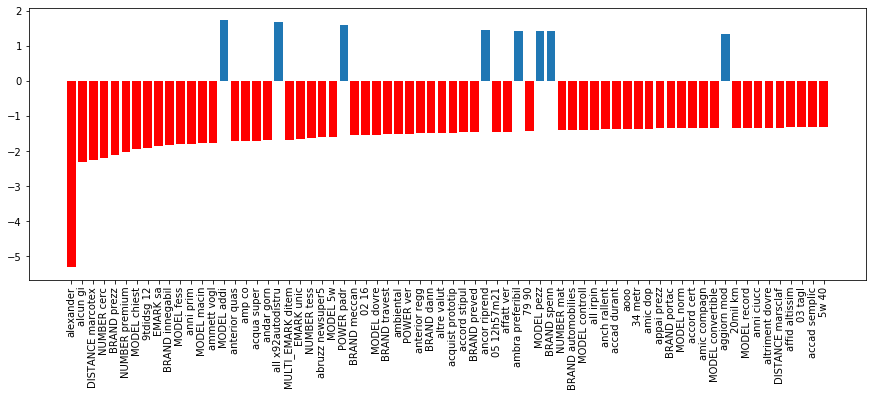

### 1


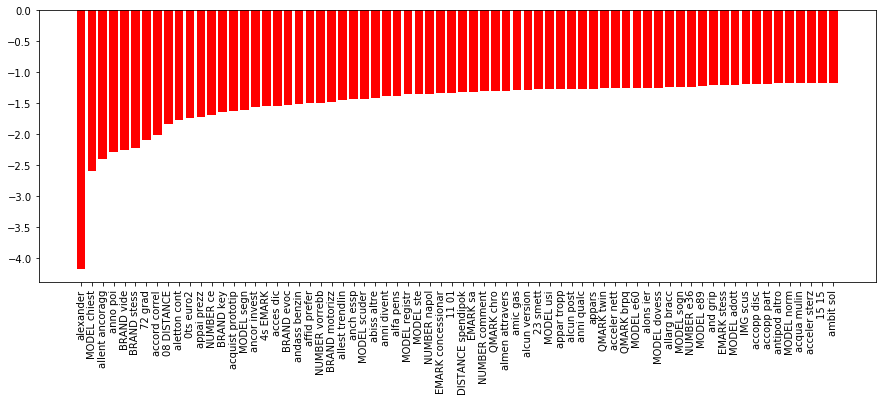

### 2


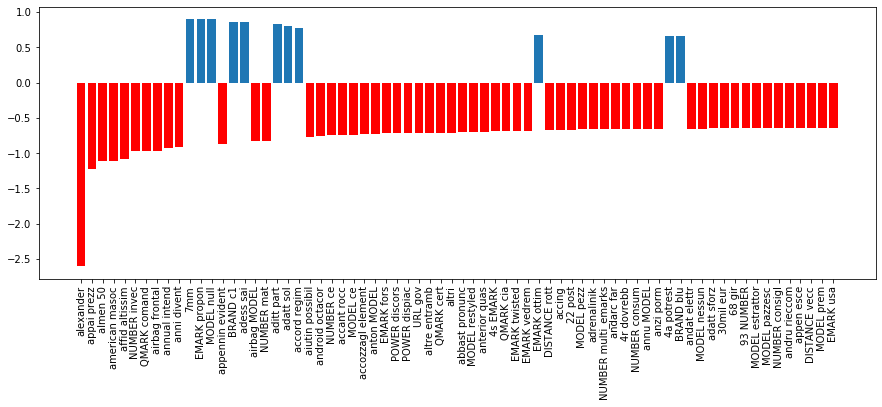

### 3


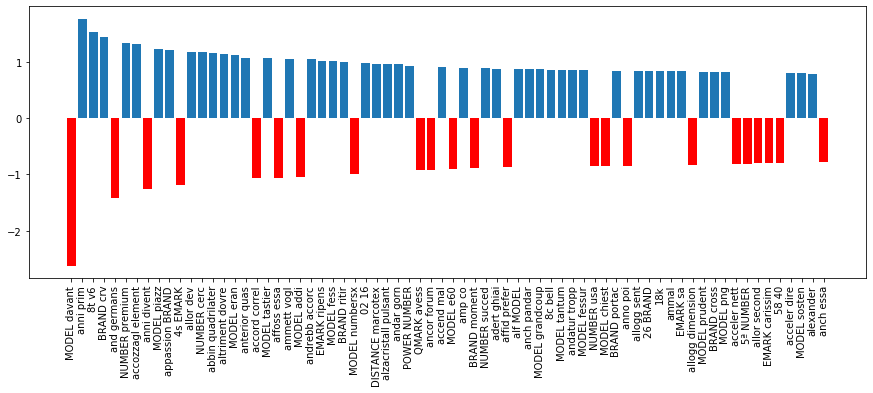

### 4


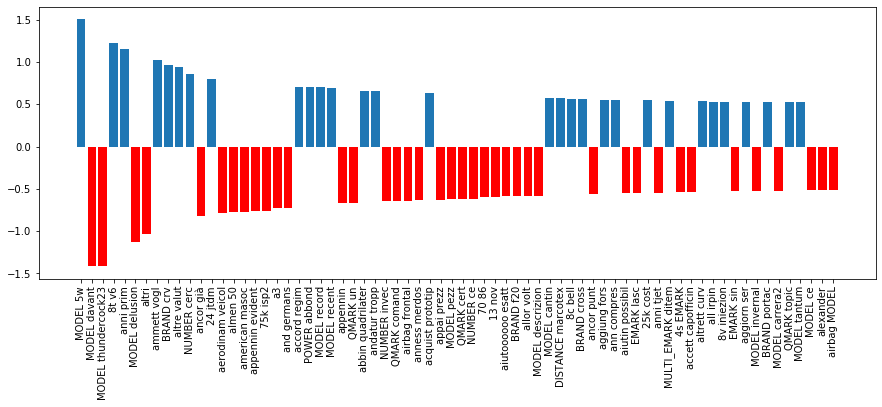

### 5


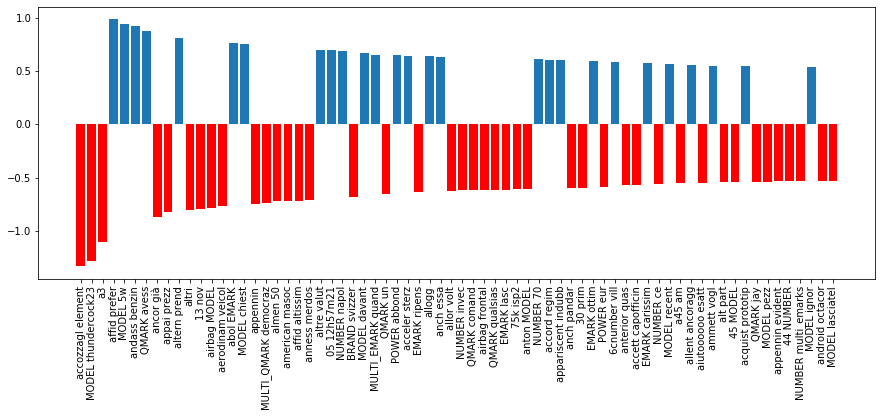

In [162]:
best_n = 70
feature_names_all = vec_all.get_feature_names()
for i in range(weights_all.shape[0]):
    print('### ' + str(i))
    fn_all = []
    fv_all = []
    f_all = [i for i in sorted(zip(map(lambda x: round(x, 4), clf_fs_all.best_estimator_.coef_[i].data), clf_fs_all.best_estimator_.coef_[i].indices), reverse=True, key=lambda k: abs(k[0]))][:best_n]
    for j in range(len(f_all)):
        fn_all.append(feature_names_all[f_all[j][1]])
        fv_all.append(f_all[j][0])
        #print(str(feature_names[f[j][1]]) + ': ' + str(f[j][0]))
    fig, ax = plt.subplots(figsize=(15,5))
    plt.bar([i for i in range(best_n) if fv_all[i]>0], [x for x in fv_all if x>0])
    plt.bar([i for i in range(best_n) if fv_all[i]<0], [x for x in fv_all if x<0], color='r')
    plt.xticks(range(best_n), fn_all, rotation='vertical')
    plt.show()

## BPEF for sentiment classification

In [163]:
class Dataset:
    
    # input dataset with labels just positive/neutral/negative
    def __init__(self, text, quote, label, feature, ner=False, use_stemmer=False, combine_text_quote=False):
        if feature not in ['word', 'pos', 'swnt']:
            raise ValueError('feature parameter must be in (\'word\', \'pos\', \'swnt\')')
        self.text = text
        self.quote = quote
        self.label = label
        self.label = self.label.replace('positivo', 0)
        self.label = self.label.replace('neutro', 1)
        self.label = self.label.replace('negativo', 2)
        self.feature = feature
        self.ner = ner
        self.use_stemmer = use_stemmer
        self.combine_text_quote = combine_text_quote
        self.combined = pd.Series()
        self.vec = CountVectorizer(ngram_range=(1,2), lowercase=False)
        self.vectorized_before_fs = None
        self.vectorized_after_fs = None
        self.selected_features = None
        self.features_entropy = None
        # fit model -> transform
        self.__fit()
        self.__feature_selection()
        # apply features selection
        self.selected_features_after_fs = self.selected_features
        self.vectorized_after_fs = self.vectorized_before_fs[:, self.selected_features_after_fs]
        
        
    def __fit(self):
        # preprocess
        self.pp = Preprocessor()
        for i in range(len(self.text)):
            self.text[i] = pp.preprocessText(self.text[i], method=self.feature, use_stemmer=self.use_stemmer, ner=self.ner)
        if self.quote is not None:
            for i in range(len(self.quote)):
                self.quote[i] = pp.preprocessText(self.quote[i], method=self.feature, use_stemmer=self.use_stemmer, ner=self.ner)
        # combine text quote
        if self.quote is not None:
            for i in range(len(self.text)):
                comb = combine_text_quote(self.text[i], self.quote[i], divide_quote=self.combine_text_quote)
                self.combined.loc[i] = comb
        else:
            self.combined = self.text
        # vectorization (count vectorizer vediamo)
        self.vectorized_before_fs = self.vec.fit_transform(self.combined)
        
            
    def transform(self, text, quote):
        combined = pd.Series()
        for i in range(len(text)):
            text[i] = self.pp.preprocessText(text[i], method=self.feature, use_stemmer=self.use_stemmer, ner=self.ner)
        if quote is not None:
            for i in range(len(quote)):
                quote[i] = self.pp.preprocessText(quote[i], method=self.feature, use_stemmer=self.use_stemmer, ner=self.ner)
        # combine text quote
        if quote is not None:
            for i in range(len(text)):
                comb = combine_text_quote(text[i], quote[i], divide_quote=self.combine_text_quote)
                combined.loc[i] = comb
        else:
            combined = text
        # vectorization (count vectorizer vediamo) and feature selection
        vectorized = self.vec.transform(combined)[:, self.selected_features_after_fs]
        return vectorized
    
    # https://www3.nd.edu/~rjohns15/cse40647.sp14/www/content/lectures/23%20-%20Decision%20Trees%202.pdf
    # https://pypi.org/project/info-gain/
    def __feature_selection(self):
        self.selected_features = [i for i in range(self.vectorized_before_fs.shape[1])]
        self.features_entropy = []
        
        #H_class = scipy.stats.entropy(self.label.value_counts())
        
        # for each feature calculate information gain
        for feat_idx in range(self.vectorized_before_fs.shape[1]):
            # print
            sys.stdout.write("\r IG: " + str(feat_idx) + '/' + str(self.vectorized_before_fs.shape[1]-1))
            sys.stdout.flush()
            '''
            H_feat = 0
            values = set(np.append(self.vectorized_before_fs[:, feat_idx].data, 0)) # zero added manually bcause sparse matrix is stupid
            # for each value calculate the conditional entropy
            for v in values:
                indexes = [i for i in range(self.vectorized_before_fs.shape[0]) if self.vectorized_before_fs[i, feat_idx] == v]
                feat_list = self.label[indexes]
                # entropy
                feat_prob = len(feat_list) / self.vectorized_before_fs.shape[0]
                H_feat += feat_prob * scipy.stats.entropy(feat_list.value_counts())
            #print(H_feat)
            # information gain of the feature
            IG = H_class - H_feat
            '''
            IG = info_gain.info_gain(self.label, self.vectorized_before_fs[:, feat_idx].toarray().ravel())
            self.features_entropy.append(IG)
            
    def plot_IG_feature(self):
        plot_ig = sorted(self.features_entropy, reverse=True)
        plt.subplots(figsize=(15,5))
        plt.semilogy(range(len(plot_ig)), plot_ig)
        plt.show()
        
    def cut_features(self, cutoff_value):
        # cut and apply features selection
        self.selected_features_after_fs = [i for i in range(len(self.features_entropy)) if self.features_entropy[i] > cutoff_value]
        self.vectorized_after_fs = self.vectorized_before_fs[:, self.selected_features_after_fs]
        

Just test

In [ ]:
dataset_test = original_dataset.copy()
dataset_test = dataset_test.drop(dataset_test[(dataset_test['Motore'] == 'irrilevante')].index).reset_index().head(50)
dataset_test['Motore'] = dataset_test['Motore'].replace('molto negativo', 'negativo')
dataset_test['Motore'] = dataset_test['Motore'].replace('molto positivo', 'positivo')
d = Dataset(text=dataset_test['TESTO'], quote=dataset_test['(Testo Citato)'], label=dataset_test['Motore'], feature='word', ner=True, use_stemmer=True, combine_text_quote=False)

In [ ]:
d.plot_IG_feature()

In [ ]:
d.cut_features(0.018)

In [ ]:
d.vectorized_after_fs

In [ ]:
d.transform(text=pd.Series(['ciao come va', 'bella zio']), quote=pd.Series(['bene grazie', '']))

One dataset for each feature set

In [ ]:
feature_values = ['word', 'pos', 'swnt']
ner_values = [False, True]

dataset_dict = {}
for f in feature_values:
    for n in ner_values:
        print(f + ' ' + str(n))
        dataset_test = original_dataset.copy()
        dataset_test = dataset_test.drop(dataset_test[(dataset_test['Motore'] == 'irrilevante')].index).reset_index().head(50)
        dataset_test['Motore'] = dataset_test['Motore'].replace('molto negativo', 'negativo')
        dataset_test['Motore'] = dataset_test['Motore'].replace('molto positivo', 'positivo')
        d = Dataset(text=dataset_test['TESTO'], quote=dataset_test['(Testo Citato)'], label=dataset_test['Motore'], feature=f, ner=n, use_stemmer=True, combine_text_quote=False)
        d.plot_IG_feature()
        dataset_dict[(f, n)] = d

In [ ]:
dataset_dict[('word', False)].cut_features(0.018)

In [ ]:
dataset_dict[('word', False)].vectorized_after_fs

### BPEF

Create dataset dictionary

word False
 IG: 41628/41628

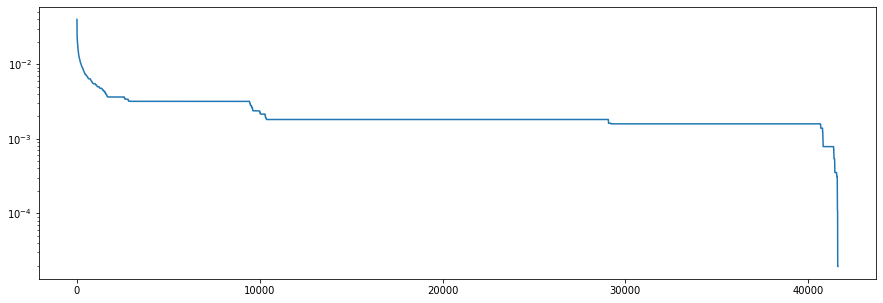

word True
 IG: 38287/38287

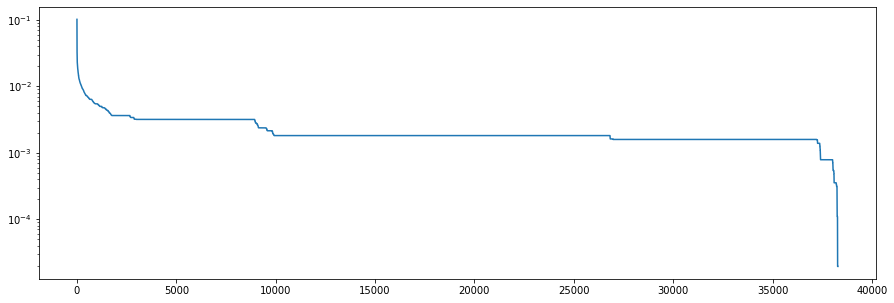

pos False
 IG: 48762/48762

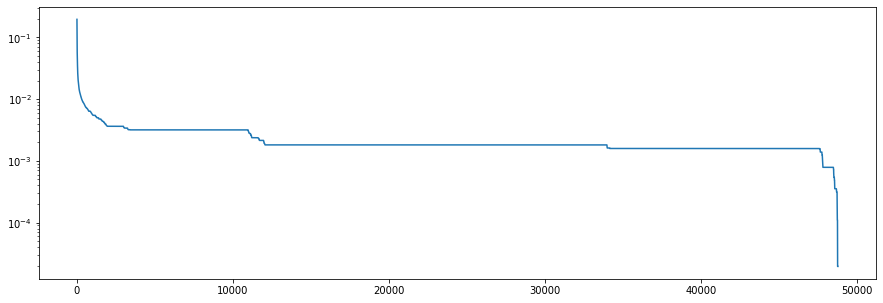

pos True
 IG: 44644/44644

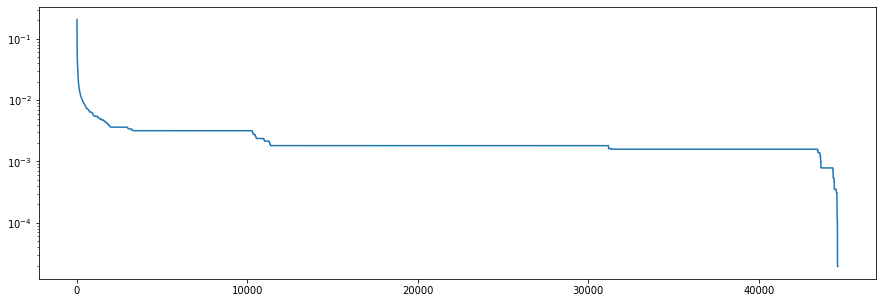

swnt False
 IG: 36695/36695

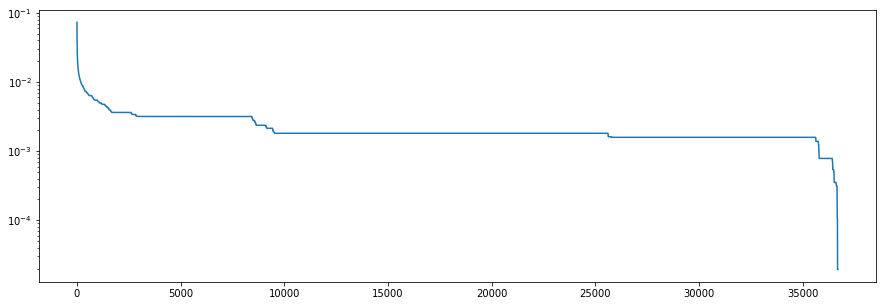

swnt True
 IG: 33433/33433

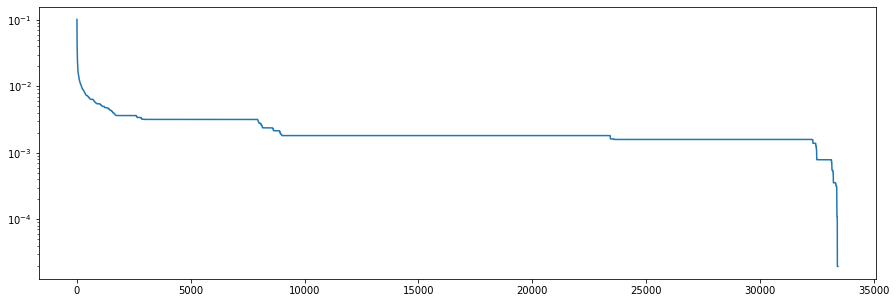

In [188]:
feature_values = ['word', 'pos', 'swnt']
ner_values = [False, True]
column = 'Motore'

dataset_bpef = original_dataset.copy()
dataset_bpef = dataset_bpef.drop(dataset_bpef[(dataset_bpef[column] == 'irrilevante')].index).reset_index()#.head(50)
dataset_bpef[column] = dataset_bpef[column].replace('molto negativo', 'negativo')
dataset_bpef[column] = dataset_bpef[column].replace('molto positivo', 'positivo')
dataset_bpef[column] = dataset_bpef[column].replace('positivo', 0)
dataset_bpef[column] = dataset_bpef[column].replace('neutro', 1)
dataset_bpef[column] = dataset_bpef[column].replace('negativo', 2)
# train validation test split

train_X_bpef, test_X_bpef, train_y_bpef, test_y_bpef = train_test_split(dataset_bpef[['TESTO', '(Testo Citato)']], dataset_bpef[column], test_size=0.2, stratify=dataset_bpef[column], shuffle=True, random_state=42)
train_X_bpef, valid_X_bpef, train_y_bpef, valid_y_bpef = train_test_split(train_X_bpef[['TESTO', '(Testo Citato)']], train_y_bpef, test_size=0.2, stratify=train_y_bpef, shuffle=True, random_state=42)
train_X_bpef = train_X_bpef.reset_index()
train_y_bpef = train_y_bpef.reset_index()[column]
valid_X_bpef = valid_X_bpef.reset_index()
valid_y_bpef = valid_y_bpef.reset_index()[column]
test_X_bpef = test_X_bpef.reset_index()
test_y_bpef = test_y_bpef.reset_index()[column]

dataset_dict = {}
for f in feature_values:
    for n in ner_values:
        print(f + ' ' + str(n))
        
        d = Dataset(text=train_X_bpef['TESTO'].copy(), quote=train_X_bpef['(Testo Citato)'].copy(), label=train_y_bpef.copy(), feature=f, ner=n, use_stemmer=True, combine_text_quote=False)
        
        d.plot_IG_feature()
        dataset_dict[(f, n)] = d


In [189]:
# cut less informative features -> cutoff at 0.0019 (heuristic)
for k in dataset_dict.keys():
    dataset_dict[k].cut_features(0.0019)
    print(str(k) + ' ' + str(len(dataset_dict[k].selected_features_after_fs)))

('word', False) 10353
('word', True) 9899
('pos', False) 12028
('pos', True) 11348
('swnt', False) 9507
('swnt', True) 8985


In [190]:
class BPEF:
    
    def __init__(self, dict_dataset):
        self.dict_dataset = dict_dataset
        
    # text plain, quote plain, labels numerical
    def train(self, text, quote, labels):
        self.classifiers_dict = {}
        keys = self.dict_dataset.keys()
        classifiers = ['svm', 'logreg', 'naibay', 'rndfst']
        # for each feature type -> keys ('feature', True/False)
        for k in keys:
            d = self.dict_dataset[k]
            # train set
            text_copy = text.copy()
            quote_copy = quote.copy()
            X = d.transform(text_copy, quote_copy)
            # train every classifier
            for c in classifiers:
                print('######## ' + str((k + (c, ))) + ' ########')
                
                if c == 'svm':
                    # train, estimate C with gridsearch
                    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
                    svmclf = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)
                    tuned_parameters = {'C': np.logspace(-3, 3, 7),}
                    clf = GridSearchCV(svmclf, tuned_parameters, cv=skf, n_jobs=-1, scoring='f1_macro', verbose=2)
                    clf.fit(X, labels)
                    print("Best parameters set found on development set:")
                    print()
                    print(clf.best_params_)
                    print()
                    print("Grid scores on development set:")
                    print()
                    means = clf.cv_results_['mean_test_score']
                    stds = clf.cv_results_['std_test_score']
                    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
                    print()
                    # add classifier to dictionary
                    self.classifiers_dict[k + (c, )] = clf.best_estimator_
                    
                elif c == 'logreg':
                    # train, estimate C with gridsearch
                    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
                    logreg = LogisticRegression(multi_class='ovr', verbose=2, random_state=42)
                    tuned_parameters = {'C': np.logspace(-3, 3, 7)}
                    clf = GridSearchCV(logreg, tuned_parameters, cv=skf, n_jobs=-1, scoring='f1_macro', verbose=2)
                    clf.fit(X, labels)
                    print("Best parameters set found on development set:")
                    print()
                    print(clf.best_params_)
                    print()
                    print("Grid scores on development set:")
                    print()
                    means = clf.cv_results_['mean_test_score']
                    stds = clf.cv_results_['std_test_score']
                    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
                    print()
                    # add classifier to dictionary
                    self.classifiers_dict[k + (c, )] = clf.best_estimator_
                    
                elif c == 'naibay':
                    # train, estimate C with gridsearch
                    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
                    naibay = GaussianNB()
                    tuned_parameters = {}
                    clf = GridSearchCV(naibay, tuned_parameters, cv=skf, n_jobs=-1, scoring='f1_macro', verbose=2)
                    clf.fit(X.toarray(), labels)
                    print("Best parameters set found on development set:")
                    print()
                    print(clf.best_params_)
                    print()
                    print("Grid scores on development set:")
                    print()
                    means = clf.cv_results_['mean_test_score']
                    stds = clf.cv_results_['std_test_score']
                    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
                    print()
                    # add classifier to dictionary
                    self.classifiers_dict[k + (c, )] = clf.best_estimator_
                    
                elif c == 'rndfst':
                    # train, estimate C with gridsearch
                    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
                    rndfst = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)
                    tuned_parameters = {'n_estimators': [201,501], 'max_features': ['auto', 'log2'], 'max_depth' : [10, 100], 'criterion' :['gini', 'entropy']}
                    clf = GridSearchCV(rndfst, tuned_parameters, cv=skf, n_jobs=-1, scoring='f1_macro', verbose=2)
                    clf.fit(X.toarray(), labels)
                    print("Best parameters set found on development set:")
                    print()
                    print(clf.best_params_)
                    print()
                    print("Grid scores on development set:")
                    print()
                    means = clf.cv_results_['mean_test_score']
                    stds = clf.cv_results_['std_test_score']
                    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
                    print()
                    # add classifier to dictionary
                    self.classifiers_dict[k + (c, )] = clf.best_estimator_
            
        
    # text quote plain
    def predict(self, text, quote):
        text_copy = text.copy()
        quote_copy = quote.copy()
        predictions = {}
        keys = self.dict_dataset.keys()
        classifiers = ['svm', 'logreg', 'naibay', 'rndfst']
        for k in keys:
            d = self.dict_dataset[k]
            # train set
            text_copy = text.copy()
            quote_copy = quote.copy()
            X = d.transform(text_copy, quote_copy)
            # train every classifier
            for c in classifiers:
                print('######## ' + str((k + (c, ))) + ' ########')
                # make prediction
                pred = self.classifiers_dict[k + (c, )].predict(X.toarray())
                predictions[k + (c, )] = pred
        # calculate the ensemble
        fin_pred = []
        for i in range(text_copy.shape[0]):
            curr_pred = []
            for k in keys:
                for c in classifiers:
                    curr_pred.append(predictions[k + (c, )][i])
            fin_pred.append(max(set(curr_pred), key = curr_pred.count))
        return fin_pred
                

In [191]:
bpef = BPEF(dataset_dict)

In [ ]:
bpef.train(train_X_bpef['TESTO'], train_X_bpef['(Testo Citato)'], train_y_bpef)

######## ('word', False, 'svm') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    4.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibSVM]Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.262 (+/-0.038) for {'C': 0.001}
0.375 (+/-0.074) for {'C': 0.01}
0.421 (+/-0.086) for {'C': 0.1}
0.426 (+/-0.077) for {'C': 1.0}
0.432 (+/-0.092) for {'C': 10.0}
0.432 (+/-0.092) for {'C': 100.0}
0.432 (+/-0.092) for {'C': 1000.0}

######## ('word', False, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.387 (+/-0.063) for {'C': 0.001}
0.405 (+/-0.082) for {'C': 0.01}
0.449 (+/-0.067) for {'C': 0.1}
0.414 (+/-0.119) for {'C': 1.0}
0.425 (+/-0.085) for {'C': 10.0}
0.418 (+/-0.048) for {'C': 100.0}
0.413 (+/-0.065) for {'C': 1000.0}

######## ('word', False, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{}

Grid scores on development set:

0.493 (+/-0.091) for {}

######## ('word', False, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}

Grid scores on development set:

0.358 (+/-0.068) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.349 (+/-0.066) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.289 (+/-0.053) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.283 (+/-0.051) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.386 (+/-0.047) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.388 (+/-0.036) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.365 (+/-0.062) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.372 (+/-0.050) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimato

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibSVM]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.287 (+/-0.013) for {'C': 0.001}
0.378 (+/-0.093) for {'C': 0.01}
0.441 (+/-0.100) for {'C': 0.1}
0.436 (+/-0.105) for {'C': 1.0}
0.439 (+/-0.085) for {'C': 10.0}
0.439 (+/-0.085) for {'C': 100.0}
0.439 (+/-0.085) for {'C': 1000.0}

######## ('word', True, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.360 (+/-0.072) for {'C': 0.001}
0.417 (+/-0.054) for {'C': 0.01}
0.450 (+/-0.083) for {'C': 0.1}
0.435 (+/-0.089) for {'C': 1.0}
0.431 (+/-0.075) for {'C': 10.0}
0.428 (+/-0.081) for {'C': 100.0}
0.424 (+/-0.057) for {'C': 1000.0}

######## ('word', True, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{}

Grid scores on development set:

0.492 (+/-0.064) for {}

######## ('word', True, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}

Grid scores on development set:

0.352 (+/-0.057) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.347 (+/-0.048) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.278 (+/-0.041) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.287 (+/-0.038) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.379 (+/-0.058) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.375 (+/-0.041) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.370 (+/-0.047) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.360 (+/-0.042) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimato

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    3.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[LibSVM]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.335 (+/-0.045) for {'C': 0.001}
0.409 (+/-0.052) for {'C': 0.01}
0.422 (+/-0.059) for {'C': 0.1}
0.433 (+/-0.090) for {'C': 1.0}
0.427 (+/-0.077) for {'C': 10.0}
0.427 (+/-0.077) for {'C': 100.0}
0.427 (+/-0.077) for {'C': 1000.0}

######## ('pos', False, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    1.8s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.377 (+/-0.071) for {'C': 0.001}
0.414 (+/-0.049) for {'C': 0.01}
0.450 (+/-0.035) for {'C': 0.1}
0.471 (+/-0.045) for {'C': 1.0}
0.446 (+/-0.061) for {'C': 10.0}
0.444 (+/-0.065) for {'C': 100.0}
0.444 (+/-0.084) for {'C': 1000.0}

######## ('pos', False, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished


Best parameters set found on development set:

{}

Grid scores on development set:

0.472 (+/-0.055) for {}

######## ('pos', False, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 501}

Grid scores on development set:

0.352 (+/-0.069) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.349 (+/-0.055) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.325 (+/-0.055) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.312 (+/-0.041) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.361 (+/-0.050) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.364 (+/-0.035) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.354 (+/-0.026) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.366 (+/-0.048) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimato

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[LibSVM]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.331 (+/-0.067) for {'C': 0.001}
0.396 (+/-0.083) for {'C': 0.01}
0.435 (+/-0.048) for {'C': 0.1}
0.439 (+/-0.059) for {'C': 1.0}
0.435 (+/-0.063) for {'C': 10.0}
0.435 (+/-0.063) for {'C': 100.0}
0.435 (+/-0.063) for {'C': 1000.0}

######## ('pos', True, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  35 | elapsed:    1.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.383 (+/-0.087) for {'C': 0.001}
0.415 (+/-0.097) for {'C': 0.01}
0.446 (+/-0.038) for {'C': 0.1}
0.429 (+/-0.043) for {'C': 1.0}
0.425 (+/-0.070) for {'C': 10.0}
0.426 (+/-0.084) for {'C': 100.0}
0.420 (+/-0.086) for {'C': 1000.0}

######## ('pos', True, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.7s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{}

Grid scores on development set:

0.466 (+/-0.078) for {}

######## ('pos', True, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}

Grid scores on development set:

0.350 (+/-0.053) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.351 (+/-0.060) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.311 (+/-0.027) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.311 (+/-0.031) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.347 (+/-0.054) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.351 (+/-0.051) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.348 (+/-0.068) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.348 (+/-0.064) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estim

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[LibSVM]Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.299 (+/-0.043) for {'C': 0.001}
0.356 (+/-0.069) for {'C': 0.01}
0.426 (+/-0.092) for {'C': 0.1}
0.436 (+/-0.069) for {'C': 1.0}
0.439 (+/-0.074) for {'C': 10.0}
0.439 (+/-0.074) for {'C': 100.0}
0.439 (+/-0.074) for {'C': 1000.0}

######## ('swnt', False, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.355 (+/-0.032) for {'C': 0.001}
0.380 (+/-0.070) for {'C': 0.01}
0.407 (+/-0.079) for {'C': 0.1}
0.410 (+/-0.059) for {'C': 1.0}
0.406 (+/-0.045) for {'C': 10.0}
0.399 (+/-0.050) for {'C': 100.0}
0.406 (+/-0.061) for {'C': 1000.0}

######## ('swnt', False, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.8s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{}

Grid scores on development set:

0.507 (+/-0.083) for {}

######## ('swnt', False, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
pred = bpef.predict(valid_X_bpef['TESTO'], valid_X_bpef['(Testo Citato)'])

In [ ]:
# 0=positivo, 1=neutro, 2=negativo
print('F1 macro score on validation data: ' + str(f1_score(valid_y_bpef, pred, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(valid_y_bpef, pred, average='micro')))
cm_fs_bpef = confusion_matrix(valid_y_bpef, pred, labels=[0, 1, 2])
ax = sns.heatmap(cm_fs_bpef, annot=True, xticklabels=['positive','neutral','negative'], yticklabels=['positive','neutral','negative'])
ax.xaxis.set_ticks_position('top')

In [ ]:
print('positive: ' + str(list(train_y_bpef).count(0)))
print('neutral: ' + str(list(train_y_bpef).count(1)))
print('negative: ' + str(list(train_y_bpef).count(2)))

Some errors

In [ ]:
# positive predicted neutral
err_pos_neu = [i for i in range(valid_y_bpef.shape[0]) if valid_y_bpef[i]==0 and pred[i]==1]
print(valid_X_bpef['TESTO'][err_pos_neu[1]])
print('################################################################')
print(valid_X_bpef['(Testo Citato)'][err_pos_neu[1]])

In [ ]:
# neutral predicted positive
err_neu_pos = [i for i in range(valid_y_bpef.shape[0]) if valid_y_bpef[i]==1 and pred[i]==0]
print(valid_X_bpef['TESTO'][err_neu_pos[1]])
print('################################################################')
print(valid_X_bpef['(Testo Citato)'][err_neu_pos[1]])

In [ ]:
# negative predicted neutral
err_neg_pos = [i for i in range(valid_y_bpef.shape[0]) if valid_y_bpef[i]==2 and pred[i]==0]
print(valid_X_bpef['TESTO'][err_neg_pos[3]])
print('################################################################')
print(valid_X_bpef['(Testo Citato)'][err_neg_pos[3]])

In [ ]:
# negative predicted neutral
err_neg_neu = [i for i in range(valid_y_bpef.shape[0]) if valid_y_bpef[i]==2 and pred[i]==1]
print(valid_X_bpef['TESTO'][err_neg_neu[1]])
print('################################################################')
print(valid_X_bpef['(Testo Citato)'][err_neg_neu[1]])

In [ ]:
valid_X

### SVM classifier

In [ ]:
# binary: relevant=1 / irrelevant=0
irr_rel_svm_predict = best_clf_fs.predict(valid_X[:, list(selected_features)])# .fit(train_X_fs, train_y_fs)
list(irr_rel_svm_predict).count(1)

In [ ]:
best_clf_fs_snt.predict(valid_X[i, list(selected_features_snt)])

In [ ]:
# sentiment: positive=0 / neutral=1 / negative=2
for i in range(len(irr_rel_svm_predict)):
    # if relevant predict sentiment
    if irr_rel_svm_predict[i] == 1:
        p = best_clf_fs_snt.predict(valid_X[i, list(selected_features_snt)]) + 1
        print(p)
        irr_rel_svm_predict[i] = p

In [ ]:
# 0=irrilevante, 1=positivo, 2=neutro, 3=negativo
print('F1 macro score on validation data: ' + str(f1_score(valid_y_fs_all, irr_rel_svm_predict, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(valid_y_fs_all, irr_rel_svm_predict, average='micro')))
cm = confusion_matrix(valid_y_fs_all, irr_rel_svm_predict, labels=[0, 1, 2, 3])
ax = sns.heatmap(cm, annot=True, xticklabels=['irrelevant','positive','neutral', 'negative'], yticklabels=['irrelevant','positive','neutral', 'negative'], fmt="d")
ax.xaxis.set_ticks_position('top')

In [ ]:
import dill
dill.dump_session('notebook_env.db')

In [ ]:
import dill
dill.load_session('notebook_env.db')